In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#function to determine a normalized probability distribution from discrete data without kernel smoothing
def pmf1d(x,nbins,range=None):
    count,edge = np.histogram(x,bins = nbins,range=range); p = count/len(x)
    idx = np.digitize(x,edge[1:-1])
    pi = p[idx]
    return p,pi,edge[:-1]+np.diff(edge)/2
#my version of non-linear fit to be used in problem 4
def PolyRegression1D(x, y, degree = 1, intercept = True):
    """one dimensional (y is a single variable function of x) fitting using an n-degree polynomial
    
    RETURNS: a dictionary 
    KEY  , VALUE
    
    ypred , estimated y values based on regression result (np.ndarray)
    co-effs , co-efficients for each degree of the polynomial in increasing order (np.ndarray)
    r2 , the r-squared value from the fit (float)
    y_residuals , difference between actual y data and the predicted y data
    
    ADDITIONAL RETURNS FOR DEGREE == 1 (fitting a line)
    
    slope_error , uncertainty in the predicted slope
    int_error , uncertainty in the predicted y-intercept
    
    """
    X = []
    if intercept:
        start = 0
    else:
        start = 1
    for i in range(start,degree+1):
        X.append(x**i)
    X = np.stack(X, axis = 1) #make matrix to solve co-efficients of
    b = np.linalg.inv(X.T@X)@X.T@y #solve for co-efficients
    yhat = X@b.reshape(-1,1) #predict y-values based on co-efficients
    yres = y-yhat #get y residuals
    yres2 = yres**2 #get squared residuals
    yvar = (y-y.mean())**2 #get un-normalized variance of y
    r2 = 1 - (yres2.sum()/yvar.sum()) #compute r-squared
    if degree == 1:
        """compute error of slope and intercept if applicable"""
        x2 = x**2
        slope_error = np.sqrt(np.sum(yres2)/((len(x)-2)*np.sum((x-x.mean())**2)))
        int_error = np.sqrt((np.sum(yres2)*x2.sum())/((len(x)-2)*len(x)*np.sum((x-x.mean())**2)))
        return dict(zip("ypred,co-effs,r2,y_residuals,slope_error,int_error".split(","),
                        [yhat,b,r2,yres,slope_error,int_error]))
    else:
        return dict(zip("ypred,co-effs,r2,y_residuals".split(","),[yhat, b, r2, yres]))
    

 (1) (Rubinstein and Colby 1.5) What is the fully extended length of a polyethylene chain with a molar mass M= 10^6 g/mol? 

In [165]:
a = 1/4
molar_mass_polymer = 1e6
molar_mass_monomer = 4 + (12*2) #approximate
n_monomers = int(molar_mass_polymer/molar_mass_monomer) #round down
length = a*n_monomers
print(f"1) The length of the polymer is ~ : {length} nm")

1) The length of the polymer is ~ : 8928.5 nm


(2) (Rubinstein and Colby 1.14) The density of 1,4-polybutadiene melt at 298 K is [Rho]=0.895 g/cm^3. What is the monomer volume given that the molar mass of the monomer is 54 g/mol?

In [225]:
density_melt = 0.895
molar_mass_monomer = 54
avogadro = 6.022e23 #approximate
mass_monomer = molar_mass_monomer/avogadro
vol_monomer = mass_monomer/density_melt
print(f"2) The volume occupied by a single monomer is ~ {vol_monomer*1e24} ang^3")

2) The volume occupied by a single monomer is ~ 100.19129115032588 ang^3


(3) (Rubinstein and Colby 1.26) Consider a polymer sample in which: 10 chains with degree of polymerization N=100, 100 chains with N=1000, and 10 chains with N=10000. 
(a) Calculate the number-average degree of polymerization Subscript[N, n].
(b) Calculate the weight-average degree of polymerization Subscript[N, w].
(c) What is the polydispersity index of the sample? 

In [226]:
#a
degs_polymerizaton = np.array([100,1000,10000])
n_chains = np.array([10,100,10])
num_weights = n_chains/n_chains.sum()
num_ave_deg_poly = degs_polymerizaton@weights
print(f"3A) number-average degree of polymerization : {num_ave_deg_poly}")

#b
"""I'll assume that each monomer has a weight of 1 g/mol (lazy), 
so that the degree of polymerization = weight of molecule"""

total_weight_per_species = degs_polymerizaton*n_chains
weight_weights = total_weight_per_species/total_weight_per_species.sum()
weight_ave_deg_poly = degs_polymerizaton@weight_weights
print(f"3B) weight-average degree of polymerization : {weight_ave_deg_poly}")

#c
poly_index = (weight_weights@degs_polymerizaton)/(num_weights@degs_polymerizaton)
print(f"3C) polydispersity index : {poly_index}")




3A) number-average degree of polymerization : 1675.0
3B) weight-average degree of polymerization : 5473.134328358209
3C) polydispersity index : 3.2675428826019157


Problem 4

In [194]:
data = np.stack([np.arange(.002,.012,.002)*1000, 
                 np.array([508,1040,1580,2150,2740])*9.86923266716e-7],axis = 1)
columns = "g/L,atm".split(",")
df = pd.DataFrame(data = data, columns = columns)
print("I convert the units to atms and g/L, as shown in the dataframe")
df

I convert the units to atms and g/L, as shown in the dataframe


,g/L,atm
0,2.0,0.000501
1,4.0,0.001026
2,6.0,0.001559
3,8.0,0.002122
4,10.0,0.002704


 # Here, I fit the data in the following form
 # I also note that a considerable amount of numerical error occours when I convert units
 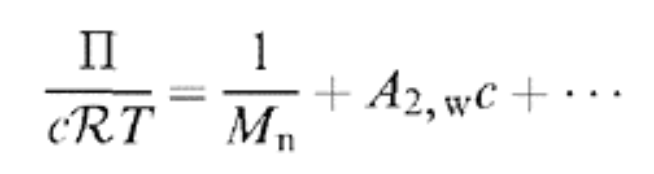

4A) Number-Average Moleular weight : 105415.40225616486 g/mol
NOTE: The molecular weight varies based on the number of parameters used in the fit
(using less parameters lowers the value)

4B) The second virial co-efficient is 6.760201170141387e-07 mol*L/g^2
the units are consistent with the form of the expansion shown in the cell above and the chosen unit conversion


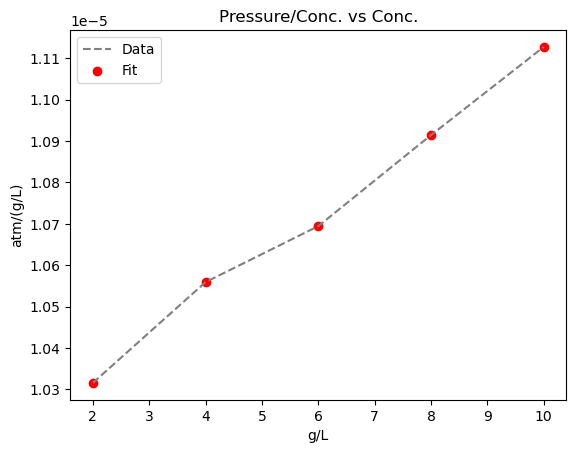

In [228]:
R = 0.082057366080960
T = 296.15
fit_result = PolyRegression1D(data[:,0], data[:,1]/(data[:,0]*R*T), degree = 4, intercept = True)
plt.figure()
plt.plot(data[:,0], data[:,1]/(data[:,0]*R*T) , label = "Data", color = "gray", ls = "--")
plt.scatter(data[:,0], fit_result["ypred"] , label = "Fit" , color = "red")
plt.ylabel("atm/(g/L)")
plt.xlabel("g/L")
plt.title("Pressure/Conc. vs Conc.")
plt.legend()
print(f"""4A) Number-Average Moleular weight : {(1/fit_result['co-effs'][0])} g/mol
NOTE: The molecular weight varies based on the number of parameters used in the fit
(using less parameters lowers the value)""")
print(f"""\n4B) The second virial co-efficient is {fit_result['co-effs'][1]} mol*L/g^2
the units are consistent with the form of the expansion shown in the cell above and the chosen unit conversion""")


Text(0.5, 1.0, 'Fluctuating Step (unitless)')

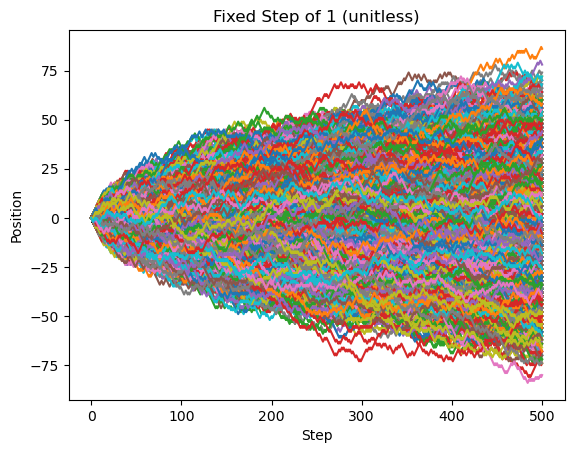

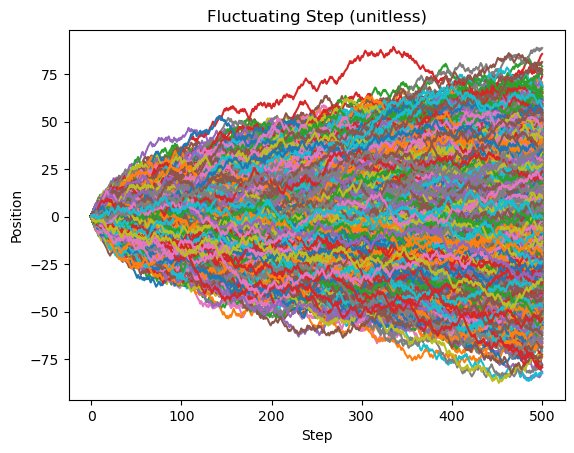

In [294]:
n_trajs = 10000
fixed_step_trajectories = np.concatenate([np.zeros(n_trajs).reshape(-1,1), 
                          np.stack([np.cumsum(np.random.choice(np.array([-1,1]), size = 500, replace = True)) 
                          for i in range(n_trajs)])], axis = 1)
plt.figure()
for i in fixed_step_trajectories:
    plt.plot(i)
plt.xlabel("Step")
plt.ylabel("Position")
plt.title("Fixed Step of 1 (unitless)")


fluctuating_step_trajectories = np.concatenate([np.zeros(n_trajs).reshape(-1,1),
        np.stack([np.cumsum(np.random.choice(np.array([-1,1]), size = 500, replace = True)*np.random.uniform(.5,1.5,500))
           for i in range(n_trajs)])], axis = 1)

plt.figure()
for i in fluctuating_step_trajectories:
    plt.plot(i)
plt.xlabel("Step")
plt.ylabel("Position")
plt.title("Fluctuating Step (unitless)")

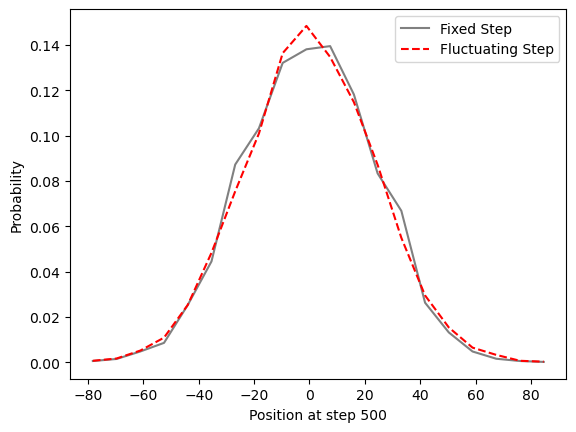

In [297]:
nbins = 20
p_fixed,_,step = pmf1d(fixed_step_trajectories[:,-1], nbins = nbins)
p_fluc,_,step = pmf1d(fluctuating_step_trajectories[:,-1], nbins = nbins)
_=plt.plot(step,p_fixed, color = "grey", label = "Fixed Step")
_=plt.plot(step,p_fluc,color = "red", label = "Fluctuating Step", ls = "--")
plt.xlabel("Position at step 500")
plt.ylabel("Probability")
plt.legend()